# Gene change analysis

This notebook provides a guide for gene change analysis used in the Mellon manuscript. Please refer to the [Density estimator single-cell analysis](https://mellon.readthedocs.io/en/latest/notebooks/basic_tutorial.html) for set up and data download instructions


Let's now load all the necessary libraries.

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import k_means
import palantir
import mellon
import scanpy as sc

import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

We are also setting some plot preferences and suppressing the NumbaDeprecationWarning for a cleaner output.

In [2]:
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = [4, 4]
matplotlib.rcParams["figure.dpi"] = 125
matplotlib.rcParams["image.cmap"] = "Spectral_r"
# no bounding boxes or axis:
matplotlib.rcParams["axes.spines.bottom"] = "on"
matplotlib.rcParams["axes.spines.top"] = "off"
matplotlib.rcParams["axes.spines.left"] = "on"
matplotlib.rcParams["axes.spines.right"] = "off"

## Step 1: Reading and Displaying the Dataset

We will start by loading the scRNA-seq dataset. For this demonstration, we will use the preprocessed T-cell depleted bone marrow data as described in the Mellon manuscript.

In [3]:
ad_url = "https://fh-pi-setty-m-eco-public.s3.amazonaws.com/mellon-tutorial/preprocessed_t-cell-depleted-bm-rna.h5ad"
ad = sc.read("data/preprocessed_t-cell-depleted-bm-rna.h5ad", backup_url=ad_url)
ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances', 'knn

Note: The annData object `ad` we loaded already has been processed from raw gene counts according to the following [notebook](https://github.com/settylab/single-cell-primers/blob/main/notebooks/PBMC-RNA-standalone.ipynb), and comes with cell-type annotations, PCA, Mellon densities, and UMAP representation. The anndata object also contains primed and lineage specific accessibility scores.

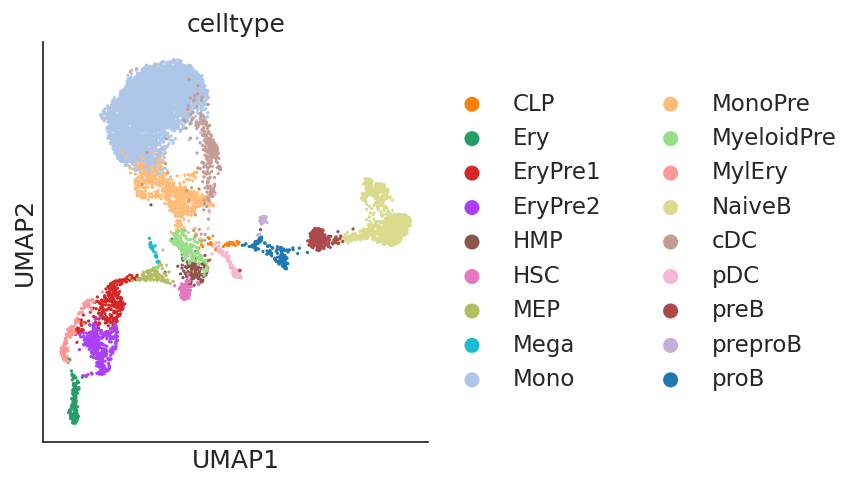

In [4]:
sc.pl.scatter(ad, basis="umap", color="celltype")

## Step 2: Compute local variability

Local variability is a measure of gene expression change in a cell-state. A score is computed for each gene and cell. First, we compute the absolute difference in expression from a cell to its neighbors and normalize by the state distance between the cells. The maximum of these normalized differences is determined as the local variability.

This functionality is implemented in `palantir.utils.run_local_variability`

In [5]:
# Local variability of genes
palantir.utils.run_local_variability(ad)

# This will add `local_variability` as a layer to anndata
ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data', 'local_variability'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivitie

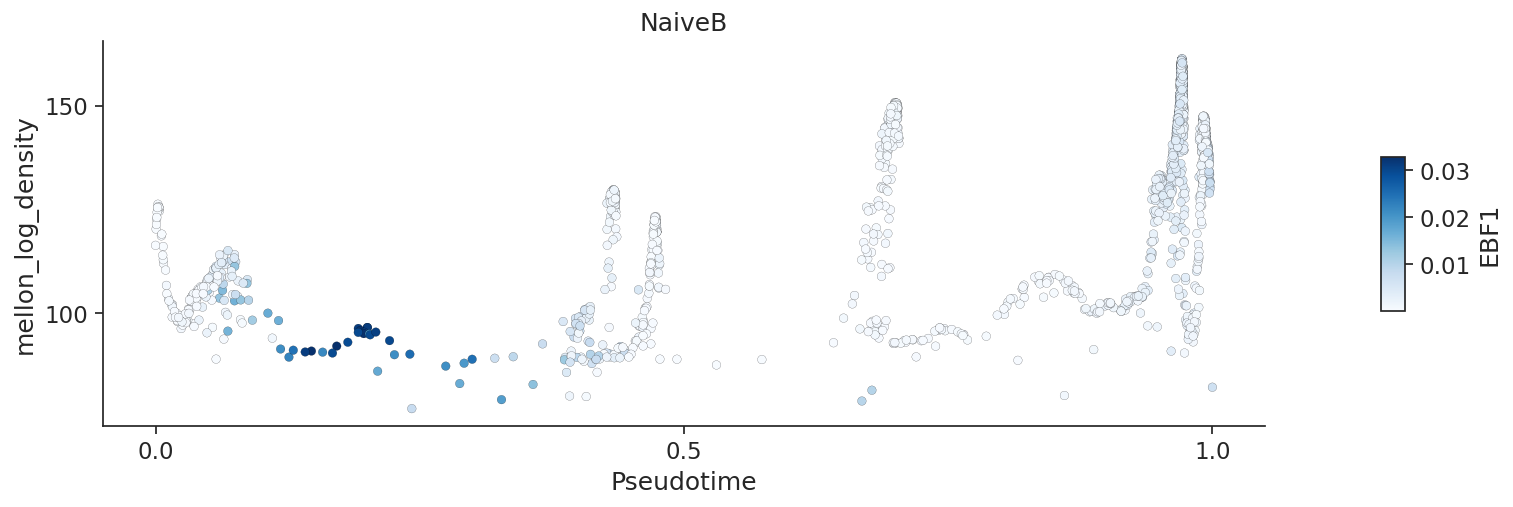

In [6]:
# Local variability  can also be visualized using `plot_branch` function
palantir.plot.plot_branch(
    ad,
    branch_name="NaiveB",
    position="mellon_log_density",
    color="EBF1",
    color_layer="local_variability",
    masks_key="palantir_lineage_cells",
    s=100,
    cmap=matplotlib.cm.Blues,
    edgecolor="black",
    linewidth=0.1,
)
plt.show()

## Step 3: Cell selection for computing gene change scores

Gene change scores for a given set of cells is the density-weighted average of local variabilities for a gene. Inverse of density is used as weights and hence gene change scores rank genes based on their changes or variability in the low-density regions amongst the selected set of cells. 


### A. Using pseudotime
Gene change analysis provides the best in scenarios where two high-density regions are connected by a low-density region, for e.g.: Cell fate specification. We will use B-cell specification to illustrate this. Cells that belong to each lineage are included in `ad.obsm["palantir_lineage_cells"]`

In [7]:
ad.obsm["palantir_lineage_cells"]

,NaiveB,Ery,pDC,Mono
IM-1393_BoneMarrow_TcellDep_1_multiome#GTGAGCGAGTCTCACC-1,False,False,False,True
IM-1393_BoneMarrow_TcellDep_1_multiome#GAGTCAAAGTCCTTCA-1,False,True,False,False
IM-1393_BoneMarrow_TcellDep_1_multiome#TGTGCGCAGTCGCTAG-1,False,True,False,False
IM-1393_BoneMarrow_TcellDep_1_multiome#ATATGTCCAATGCCTA-1,False,False,False,True
IM-1393_BoneMarrow_TcellDep_1_multiome#CTTAGTTTCGCTAGTG-1,False,True,False,False
...,...,...,...,...
IM-1393_BoneMarrow_TcellDep_2_multiome#ATCCGTGAGGGATTAG-1,False,False,False,True
IM-1393_BoneMarrow_TcellDep_2_multiome#ATTTAGGTCAGGTTTA-1,False,False,False,True
IM-1393_BoneMarrow_TcellDep_2_multiome#GATGGACAGATAAAGC-1,False,False,False,True
IM-1393_BoneMarrow_TcellDep_2_multiome#GAAGGCTAGCTATATG-1,False,False,False,True


Examining the B-cell lineage further:

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


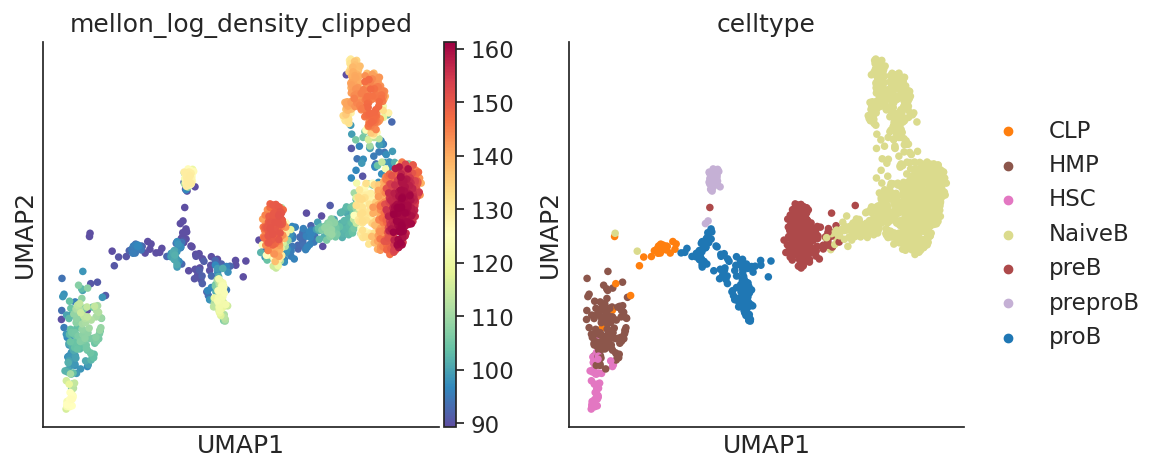

In [8]:
# Plot of UMAP
sc.pl.embedding(
    ad[ad.obsm["palantir_lineage_cells"]["NaiveB"]],
    basis="umap",
    color=["mellon_log_density_clipped", "celltype"],
)
plt.show()

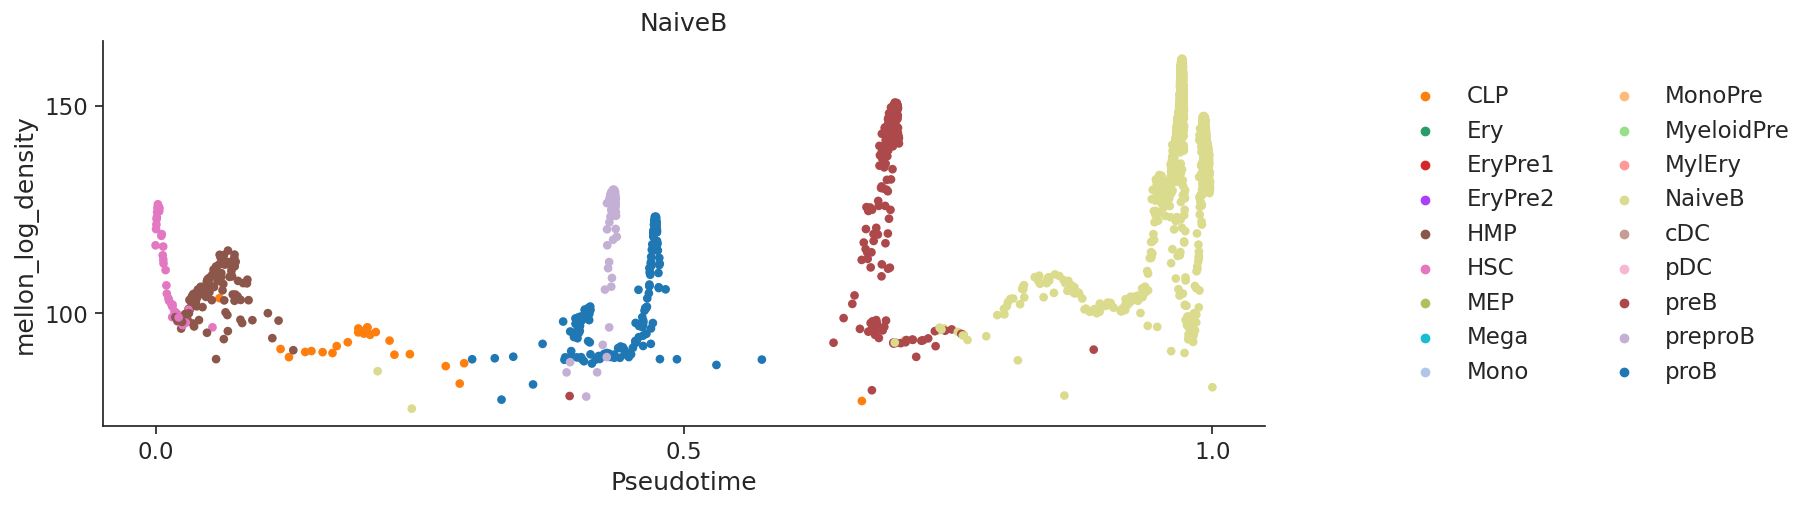

In [9]:
# Compare pseudotime to log density
palantir.plot.plot_branch(
    ad,
    branch_name="NaiveB",
    position="mellon_log_density",
    color="celltype",
    masks_key="palantir_lineage_cells",
    s=100,
)
plt.show()

Since `preproB` is defined by cell-cycle, we will select the subset of cells that form the early stages of B-cell differentiation - and select  the subset of these cells of `HSC`, `HMP`, `CLP`, `proB` cell-types to identify genes that drive low-density state transitions during B-cell specification from stem cells

In [10]:
bcell_specification_cells = (
    ad.obs["celltype"].isin(["HSC", "HMP", "CLP", "proB"])
    & ad.obsm["palantir_lineage_cells"]["NaiveB"]
)
ad.obsm["specification"] = pd.DataFrame({"Bcells": bcell_specification_cells})

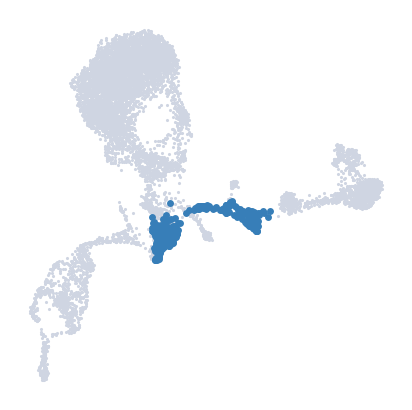

In [11]:
# Verify that the selected set of cells is correct
palantir.plot.highlight_cells_on_umap(ad, bcell_specification_cells)
plt.show()

### B. Using clusters

Cells can also be selected based on leiden clustering 

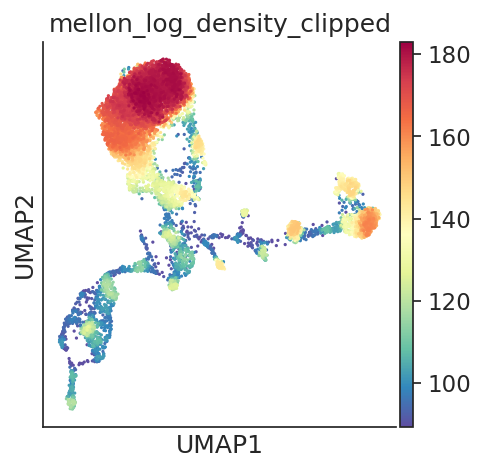

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


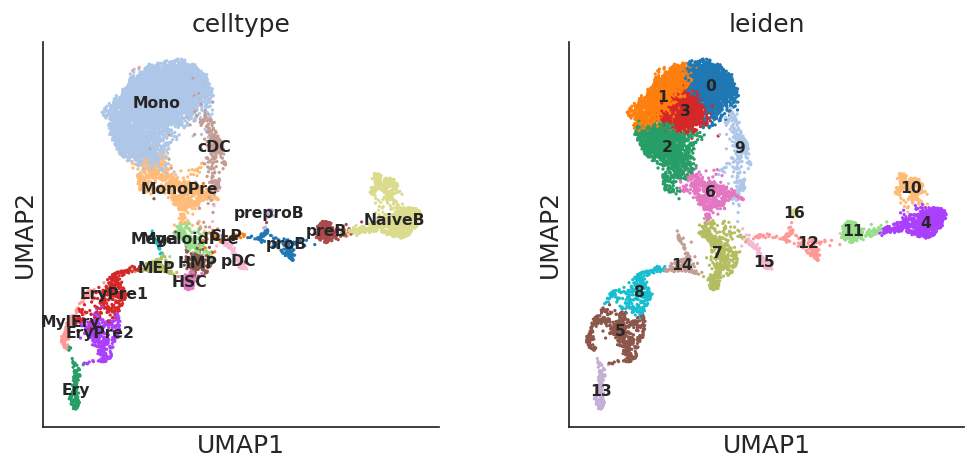

In [12]:
sc.pl.embedding(ad, basis="umap", color=["mellon_log_density_clipped"])
sc.pl.embedding(
    ad,
    basis="umap",
    color=["celltype", "leiden"],
    legend_loc="on data",
    legend_fontsize=9,
)
plt.show()

To investigate the transition from `MEP` to `EryPre`, one can choose cells using

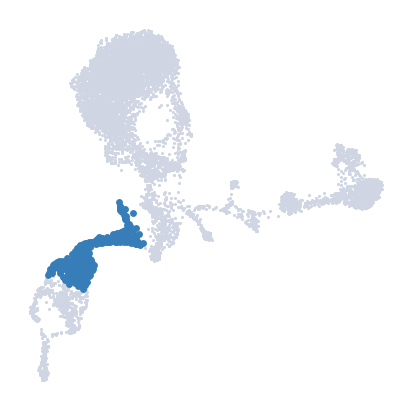

In [13]:
cells = ad.obs_names[ad.obs["leiden"].isin(["8", "14"])]
palantir.plot.highlight_cells_on_umap(ad, cells)
plt.show()

## Step 4: Gene change scores

Now we can compute gene change scores for the selected set of cells. This involves two steps

1. Re-computing density with low intrinsic dimensionality to make sure weights are representative
2. Computing scores for each gene


In [14]:
# 1. Re-computing density with low intrinsic dimensionality to make sure weights are representative
dm_res = palantir.utils.run_diffusion_maps(ad, pca_key="X_pca", n_components=20)
model = mellon.DensityEstimator(d_method="fractal")
log_density = model.fit_predict(ad.obsm["DM_EigenVectors"])

ad.obs["mellon_log_density_lowd"] = log_density

Determing nearest neighbor graph...
[2023-07-09 04:22:51,241] [INFO    ] Computing nearest neighbor distances.
[2023-07-09 04:22:51,934] [WARNING ] Using EXPERIMENTAL fractal dimensionality selection.
[2023-07-09 04:22:53,042] [INFO    ] Using d=1.765716771502544.
[2023-07-09 04:22:53,224] [INFO    ] Using covariance function Matern52(ls=0.007897131365355458).
[2023-07-09 04:22:53,226] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2023-07-09 04:22:55,843] [INFO    ] Doing low-rank Cholesky decomposition for 8,627 samples and 5,000 landmarks.
[2023-07-09 04:23:00,868] [INFO    ] Using rank 5,000 covariance representation.
[2023-07-09 04:23:01,886] [INFO    ] Running inference using L-BFGS-B.


In [15]:
# 2. Computing scores for each gene
score_key = "change_scores"
palantir.utils.run_low_density_variability(
    ad,
    cell_mask="specification",
    density_key="mellon_log_density_lowd",
    score_key=score_key,
)
plt.show()

This updateds `ad` with change scores in `ad.var['change_scores_Bcells']`

### Ranking of genes

In [16]:
scores = ad.var["change_scores_Bcells"]
scores.sort_values(ascending=False)

DIAPH3        1.283495e-03
EBF1          1.244682e-03
ERG           1.163010e-03
NEGR1         1.101689e-03
AL589693.1    1.071112e-03
                  ...     
AL162464.1    1.027674e-10
AC097504.2    6.912636e-11
AC110741.1    3.257078e-11
BTNL8         1.406085e-12
AC138207.5    0.000000e+00
Name: change_scores_Bcells, Length: 17226, dtype: float64

We recommoned the use of top 5% of genes for downstream analysis

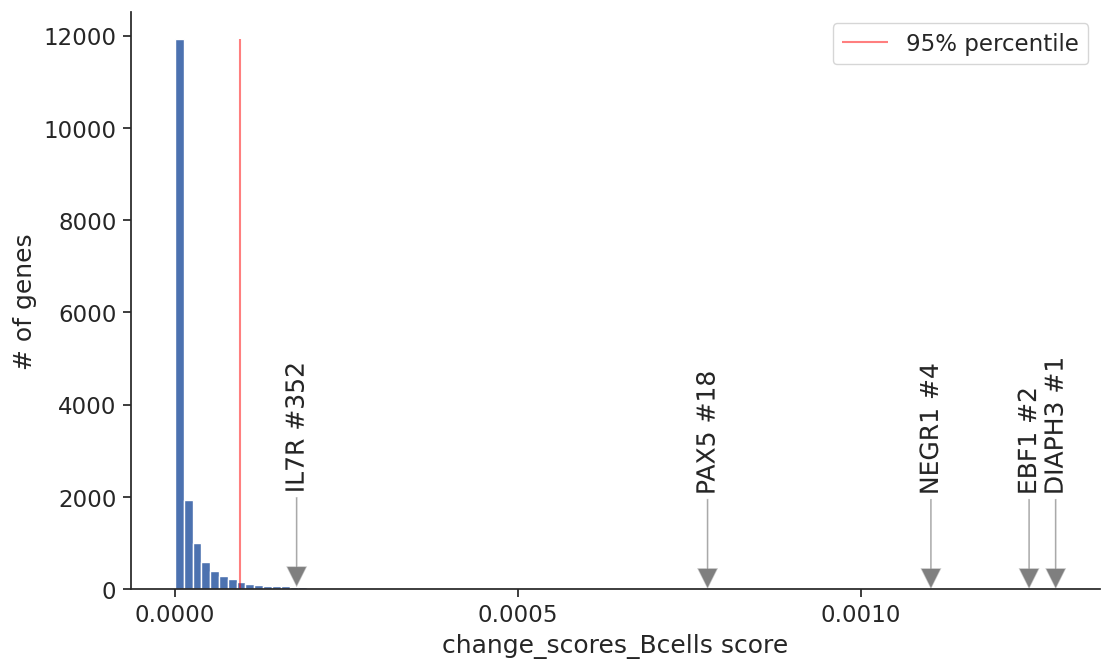

In [17]:
# The scores can be visualized as a histogram. Some important genes are highlgited below
highlight_gene = ["EBF1", "PAX5", "IL7R", "NEGR1", "DIAPH3"]

palantir.plot.gene_score_histogram(ad, "change_scores_Bcells", highlight_gene)
plt.show()

Note that we further removed cells with `pseudotime>0.5` in the manuscript to focus exclusively on B-cell specification

In [18]:
percentile = 0.95
percentile_cutoff = np.quantile(scores, percentile)
scores = scores.sort_values(ascending=False)
bcell_change_genes = scores.index[scores >= percentile_cutoff]

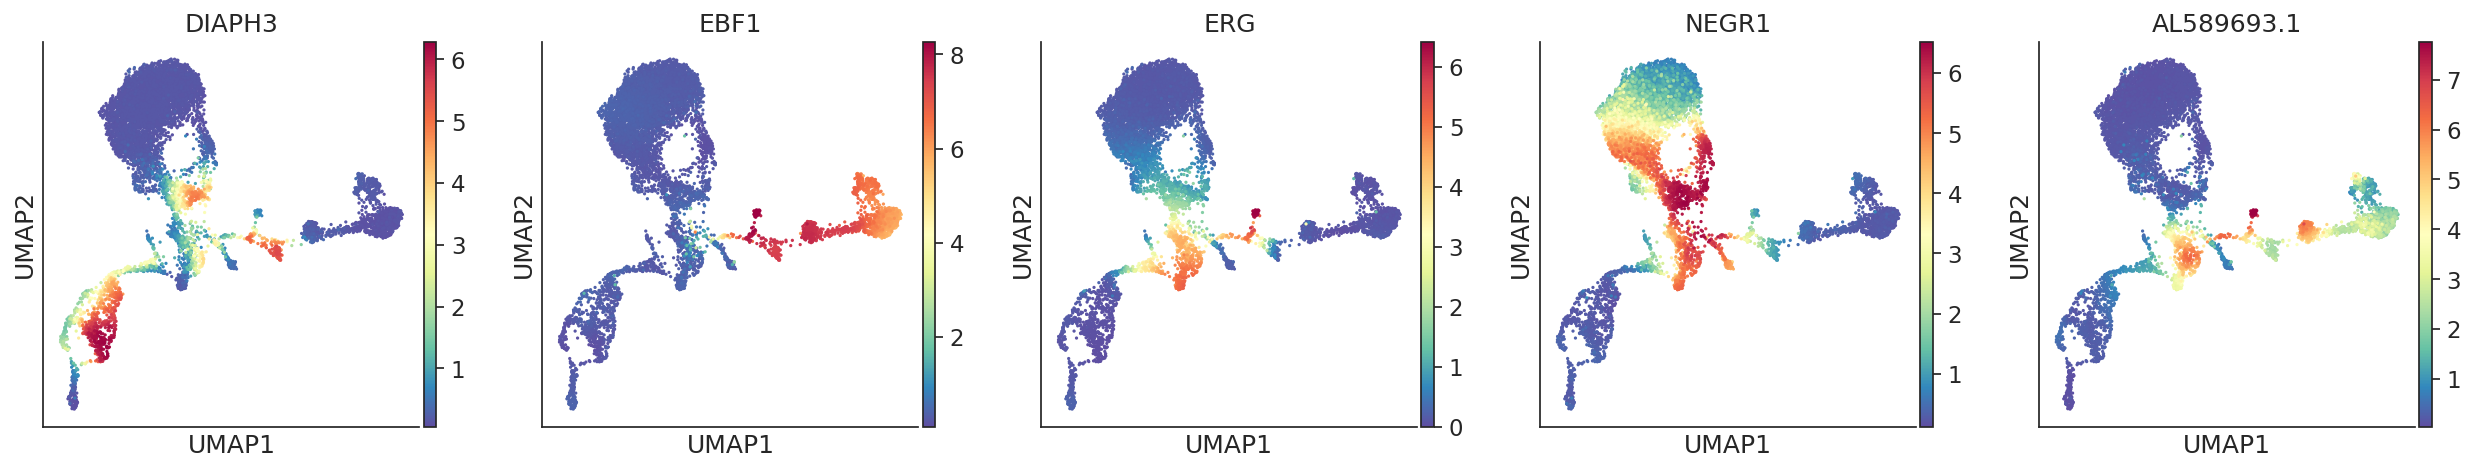

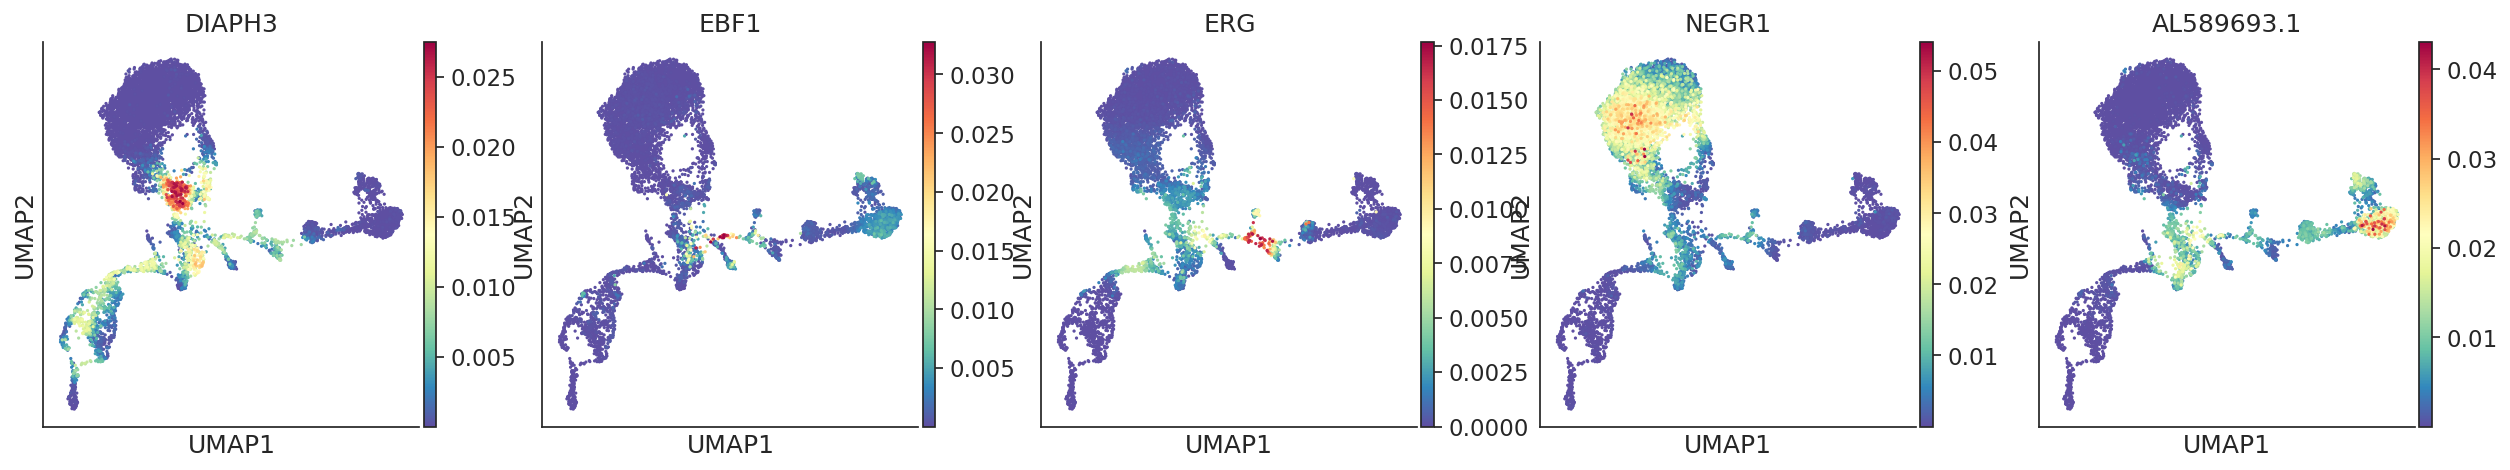

In [19]:
# Visualize the expression and variability of top 5 genes
sc.pl.embedding(
    ad,
    basis="umap",
    color=bcell_change_genes[:5],
    layer="MAGIC_imputed_data",
    ncols=5,
)
sc.pl.embedding(
    ad,
    basis="umap",
    color=bcell_change_genes[:5],
    layer="local_variability",
    ncols=5,
)
plt.show()

### Expression trends

We can compute gene expression trends for these genes to visualize their expression dynamics along pseudotime. This will update `ad.varm["gene_trends_Bcells"]`.

In [20]:
_ = palantir.presults.compute_gene_trends(ad, ls=5, masks_key="specification")

Bcells
[2023-07-09 04:23:13,674] [INFO    ] Using covariance function Matern52(ls=5.0).


Heatmap of these genes can be plotted using `sns.clustermap`

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


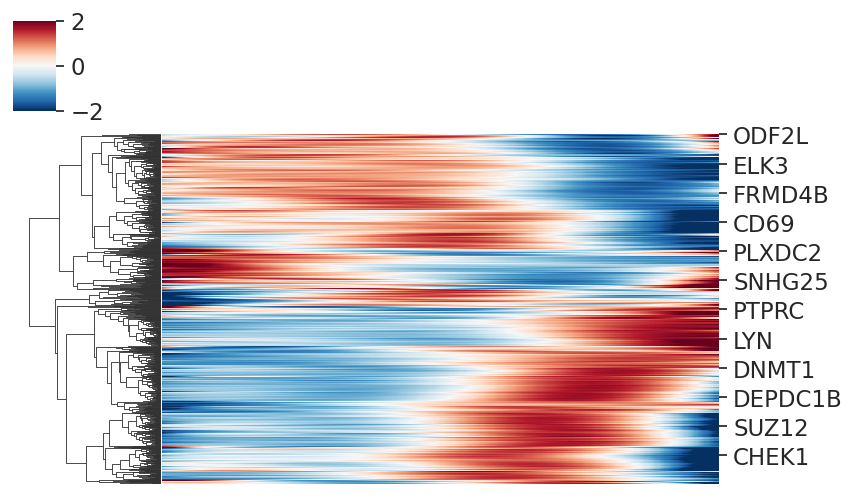

In [21]:
# Plot
import seaborn as sns

selected_trends = ad.varm["gene_trends_Bcells"].loc[bcell_change_genes, :]

sns.clustermap(
    selected_trends,
    z_score=0,
    cmap="RdBu_r",
    col_cluster=False,
    vmin=-2,
    vmax=2,
    figsize=[7, 4],
    xticklabels=0,
)
plt.show()

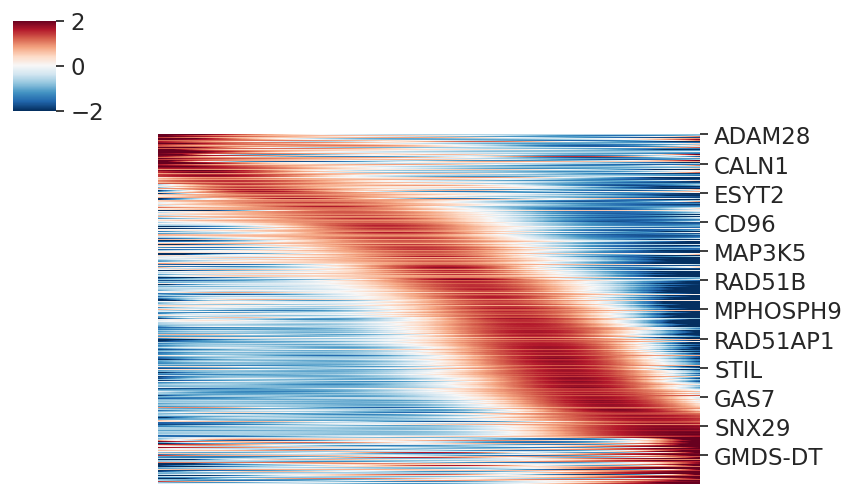

In [22]:
# Alternatively sort by maximum exprression bin for clean visualization
plot_order = selected_trends.idxmax(axis=1).sort_values().index
sns.clustermap(
    selected_trends.loc[plot_order, :],
    z_score=0,
    cmap="RdBu_r",
    col_cluster=False,
    row_cluster=False,
    vmin=-2,
    vmax=2,
    figsize=[7, 4],
    xticklabels=0,
)
plt.show()